# Bayesian Regression

## Gaussian Model of Height

Lets build a linear regression model now. Well, it'll be a 'regression' once we have a predictor variable in it. For not we'll get the scaffold in place and construct the predictor variable in the next section.

We'll work through this material by using real sets of data. In this case we want a single measurement variable to be modelled as a gaussian distribution. There will be two parameters describing the distributions' shape, the mean (mu) and the standard deviation (sigma). Bayesian updating will allow us to consider every possible combination of values for mu and sigma and to score each combination by its relative plausability, in light of data. These relative plausabilities are the posterior probabilities of each combination of values mu, sigma.

Another way to say the above is this. There are an infinite number of possible Gaussian distributions. Some have small means, others have large means. Some are wide, others are narrow. We want our bayesian machine to consider every possible distribution, each defined by a combination of mu and sigma, and rank them by posterior plausability. Posterior plausability provides a measure of the logical compatability of each possible distribution with the data and the model

In practice we'll user approximations to the formal analysis. So we won;t really consider every possible value of mu and sigma. But that won't cost us anything in most cases. Instead the thing to worry about is keeping in mind that the 'estimate' here will be the entire posterior distribution, not any point within it. And as a result the posterior distribution will be a distribution of gaussian distributions.

### The data
The data used in this example is a partial sensus for the Dobe area !Kung San, compiled from interviews conducted by Nancy Howell in the late 1960's.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
input_file = 'kung.csv'
input_data = pd.read_csv(input_file,delimiter=';')

adult_data = input_data[input_data['age']>= 18]

In [3]:
adult_data.describe()

height      weight         age        male
count  352.000000  352.000000  352.000000  352.000000
mean   154.597093   44.990486   41.138494    0.468750
std      7.742332    6.456708   15.967855    0.499733
min    136.525000   31.071052   18.000000    0.000000
25%    148.590000   40.256290   28.000000    0.000000
50%    154.305000   44.792210   39.000000    0.000000
75%    160.655000   49.292693   51.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000

Our goal is to model these values using a Gaussian distribution. First go ahead and plot the distribution of heights.

<AxesSubplot:ylabel='Frequency'>

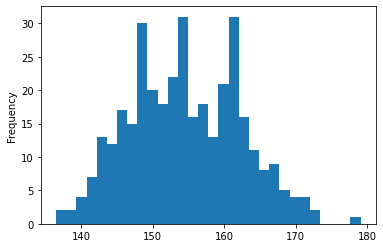

In [4]:
adult_data['height'].plot(kind='hist', bins=30)

These data look rather gaussian in shape, as is typical of height data. This may bee because height is a sum of many small growth factors. As you saw at the start of the chapter, a distributions of sums tends to converge on a Gaussian distribution. Whatever the reason, adult heights from a single population are nearly always nearly approximately normal.

So its reasonable for the moment to adopt a stance that the mode should use a Gaussian distribtuion for the probability distribution of ther data. But be careful about choosing the Gaussian distribution only when the plotted variable looks Gaussian to you. Gawking at the raw data, to try to decide how to model them, is not usually a good idea. The data could be a mixture of different Gaussian distributions, for example, and in that case you won't be able to detect the underlying normality just by eyeballing the outcome distribution. Furthermore as mentioned earlier in this chapter the empirical distribution needn't actually be Gaussian in order to justify using a Gaussian probability distribution.

So which Gaussian distribution? there are an infinite number of them, with infinite number of means and standard deviations. We are ready to write down the general model and compute the plausability of each combination of mu and sigma. To define the heights as normally distributed with mean mu and standard deviation sigma, we write:

$ h_{i} = Normal(mu,sigma)$

The symbol h refers to the list of heights, and the subscript i means 'each individual element of the list'/ It is conventional to use i because it stands for 'Index'. The index i takes on row numbers, and so in this example can take any value from 1 to 352 (the number of heights in the dataset). As such, the model above is saying that all the golem knows about each height measurement is defined by the same normal distribution, with mean mu and standard deviation sigma. Before long, those little i's are going to show up on the right-hand side of the model definition, and you'll be able to see why we must bother with them. So don't ignore the i, even if it seems like useless ornamentation right now

### Priors

To complete the mode, we're going to need some priors. The parameters to be estimated are both mu and sigma, so we nede a prior Pr(mu,sigma), the joint prior probability for all parameters. In most cases, priors are specified independently for each paramerer, which amounts to assuming Pr(mu,sigma) = Pr(mu)Pr(sigma). Then we can write:

$h_{i} = Normal(mu,sigma)$ <br>
$mu = Normal(178,20)$ <br>
$sigma = Uniform(0,50)$ <br>

The prior for mu is a broad Gaussian prior, centered on 178cm, with 90% probability between 178 +- 40.

Why 178cm? Your author is 178cm tall. And the range from 138cm to 218cm encompasses a huge range of plausable mean heights for human populations. So domain-specific information has gone into this prior. Everyone knows something about human height and can set a reaonable vague prior of this kind. But in many regression problems, as you'll see later, using prior information is more subtle, because parameters don't always have such clear physical meaning


Whatever the prior, its a very god idea to plot your priors, so you have a sense of the assumption they build into the model.

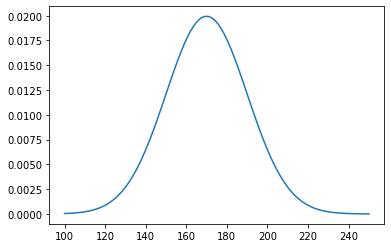

In [5]:
from scipy.stats import norm
import numpy as np

x = np.linspace(100,250,num=100)
y = norm.pdf(x, loc=170, scale=20)

plt.plot(x,y)

As you can see the golem is assuming that the average height (not each individial height) is almosty certainly between 140cm and 220cm. So this prior carries a little information but not a lot. The sigma prior is a truly flat prior, a uniform one, that functions just to constrain sigma to have a positive probability between zero and 50cm. Lets plot that.

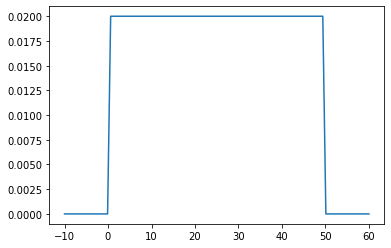

In [6]:
from scipy.stats import uniform
x = np.linspace(-10,60, num=100)
y = uniform.pdf(x,loc=0,scale=50)
plt.plot(x,y)

A standard deviation like sigma must be positive, so bounding it as zero makes sense. How should we pick the upper bound? In this case, a standard deviation of 50cm would imply that 95% of individual heights lie within 100cm of the average height. That is a very large range.

All this talk is nice, but it'll help to really see what these priors imply about the distribution of individual heights. This is an essential part of your modelling, the PRIOR PREDICTIVE simulation. Once you've chosen priors for h,mu and sigma, these imply a joint prior distributuon of individual heights. By Simulating from this distribution, you can see what your choices imply about observable height. This helps you diagnose bad choices. Lots of conventional choices are indeed bad ones, and we'll be able to see this by conducting prior predictive simulations.

Okay, so how do we do this? You can quickly simulate heights by smapling from the prior, like you sampled from the posterior back in chapter 3. Remember, every posterior is also a potential prior for a subsequent analysis, so you can process priors just like posteriors

(array([1.16951059e-05, 1.16951059e-05, 2.33902118e-05, 4.67804237e-05,
        1.16951059e-05, 2.33902118e-05, 5.84755296e-05, 1.52036377e-04,
        2.33902118e-04, 3.74243389e-04, 5.37974872e-04, 8.42047626e-04,
        1.19290080e-03, 1.73087568e-03, 2.37410650e-03, 3.69565347e-03,
        5.59026063e-03, 7.14570971e-03, 9.70693791e-03, 1.16132402e-02,
        1.28646165e-02, 1.27476654e-02, 1.15196793e-02, 9.91744981e-03,
        7.66029437e-03, 5.27449277e-03, 3.89447027e-03, 2.54953309e-03,
        1.82443652e-03, 1.06425464e-03, 7.48486778e-04, 6.90011249e-04,
        2.68987436e-04, 2.57292330e-04, 1.16951059e-04, 3.50853177e-05,
        5.84755296e-05, 4.67804237e-05, 2.33902118e-05, 1.16951059e-05]),
 array([ -1.35468728,   7.19589796,  15.7464832 ,  24.29706844,
         32.84765368,  41.39823892,  49.94882416,  58.4994094 ,
         67.04999464,  75.60057988,  84.15116512,  92.70175036,
        101.2523356 , 109.80292084, 118.35350608, 126.90409132,
        135.45467656, 

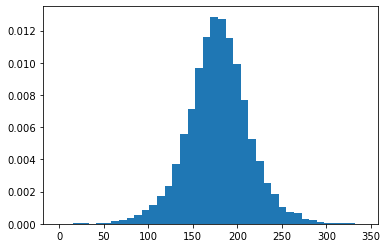

In [7]:
mu_prior = norm(loc=178, scale = 20)
sd_prior = uniform(loc = 0, scale = 50)

#draw 10000 samples from the height prior(normal dist) using the parameter prior values as inputs

h_list = []
for i in range(10000):
    h_list.append(norm.rvs(loc = mu_prior.rvs(), scale = sd_prior.rvs()))
    
plt.hist(h_list, bins=40, density = True)

This density displayes a vaguely bell-shaped density with thick tails. It is the expected distribution of heights, averaged over the prior. Notice that the prior probability of height is not itself gaussian. This is ok. The distribution you see is not an empirical expectation, but rather the relative plausabilities of different heights, before seeing the data.

Prior predictive simulation is very useful for assigning sensible priors, because it can be quite hard to anticipatehow priors influence the observable variables. As an example, consider a much flatter and less informative prior like mu=178,100. Priors with such large standard deviations are quite common in bayesian models, but are hardly ever sensible. Lets re-plot the prior predictive distribution with this changed and see how it looks

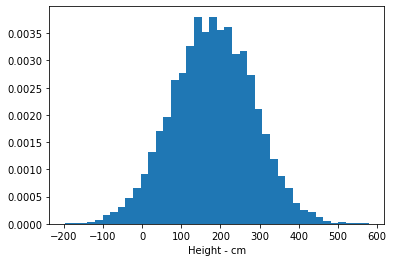

In [8]:
mu_prior = norm(loc=178, scale = 100)
sd_prior = uniform(loc = 0, scale = 50)

#draw 10000 samples from the height prior(normal dist) using the parameter prior values as inputs

h_list = []
for i in range(10000):
    h_list.append(norm.rvs(loc = mu_prior.rvs(), scale = sd_prior.rvs()))
    
plt.hist(h_list, bins=40, density = True)
plt.xlabel('Height - cm')
plt.show()

The result is displayed above. Now the model, before seeing the data expects a certain percentage of people to have a negtive height. It also expects some giants. One of the tallest people in history, Robert Pershing Wadlow stood 272cm tall. In out prior predictive simulation, 18% of people are taller than this.

Does this matter? It is true that even this silly prior is harmless. But that won't always be the case, there are plenty of inference problems for which the data alone are not sufficient, no matter how numerous. Bayes lets us proceed in these cases, but only if we use our scientific knowledge to construct sensible priors.

### Grid Approximation of the posterior distribution

Since this is the first Gaussian model we'll go through, and indeed the first model with more than one parameter, its work quickly mapping out the posterior distribution through brute force calculations. This isn't the approach I encourage in any other place, because it is laborious and computationally expensive. Indeed it is usually so impractivcal as to be essentially impossible. But as always, it is worth knowing what the large actually looks like, before you start accepting approximations of it. A little later in this chapter, you'll use quadratic approximationto estimate the posterior distribution, and thats the approach you'll use for several chapters more. Once you have the samples you'll produce in this subsection, you can compare them to the quadratic approximation in then next.

In [9]:
from itertools import product

# create the grid
mu_grid = np.linspace(140,160,num=100)
sigma_grid = np.linspace(4,9,num=100)

grid_sample = list(product(mu_grid,sigma_grid))


In [10]:
# calculate the likelihood
likelihood = [sum(norm.logpdf(adult_data['height'], loc=i[0], scale=i[1])) for i in grid_sample]

# transform the independent samples into an array so we can start to operate on them as a group
post = np.asarray(grid_sample)

In [11]:
# combine the likelihood with the prior - remember this is in log space so we can add them together

post_prod = (likelihood + 
             norm.logpdf(post[:,0], loc=178, scale=20) + 
             uniform.logpdf(post[:,1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))

In [12]:
post_prob

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.55262527e-31, 1.96043306e-31, 2.41146933e-31])

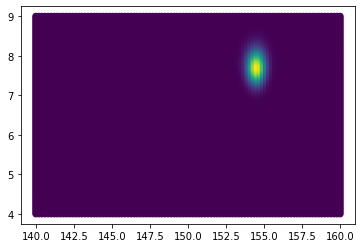

In [13]:
grid_sample_array = np.asarray(grid_sample)

plt.scatter(grid_sample_array[:,0],grid_sample_array[:,1], c=post_prob)

### Sampling from the posterior

To Study this posterior distribution in more detail, lets use the flexable approach of sampling parameter values from it. This works in a very similar way to the univariate sampling (using something like np.random.choice, with a p argument) The only trick is that since there are two parameters, and we want to sample combinations of them, we first randomly sample row numbers in 'post' in proportion to the values in post_prob. Then we pull out the parameter values on those randomly sampled rows.

Text(0, 0.5, 'sample_sigma')

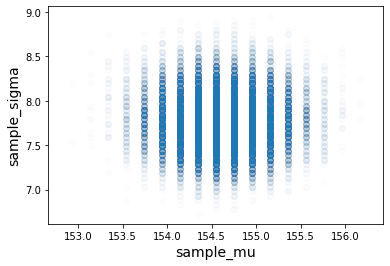

In [14]:
#sample the from the grid sample by its index
sample_rows = np.random.choice(np.arange(len(post)), size=30000, replace=True, 
                               p=(post_prob/post_prob.sum()))

# Then extract the mu and sigma from the extracted samples
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, 'o', alpha=0.01)
plt.axis('equal')
plt.grid(False)
plt.xlabel('sample_mu', fontsize=14)
plt.ylabel('sample_sigma', fontsize=14)

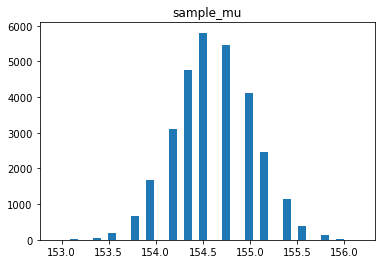

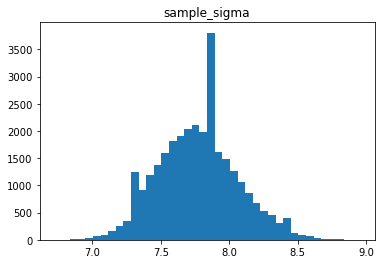

In [15]:

plt.hist(sample_mu, bins=40)
plt.title('sample_mu')
plt.show()
plt.hist(sample_sigma, bins=40)
plt.title('sample_sigma')
plt.show()

 ## Finding the posterior distribution with Quadratic (Normal) approximation
 Now we leave grid approximation behind and move on to one of the great engines of applied statistics - THE QUADRATIC APPROXIMATION. Our interest in quadratic approximation, recall, is as a handy way to make inferences about the shape of the posterior. The posteriors peak will lie at the maximum a posteriori estimate (MAP), and we can get a useful image of the posteriors shape by using the quadratic approximation of the posterior distribution at its peak.
 
To build the quadratic approximation, we are going to transition to one of the most useful probabilistic programming frameworks pyMC. The NormalApproximation engine inside pyMC uses the mode defintion you have provided to define the posterior probability at each combination of your parameter values. Then it can climb the posterior distribution and find the peak, its MAP. Finally it estimates the quadratic curvature at the MAP to produce an approximation of the posterior distribution. Remember, this is very similar to what many non-bayesian procedures do, just without the priors.

In [40]:
import pymc3 as pm
import arviz as az

In [17]:
# import the data again as we are going to repeat the modelling exercise
input_file = 'kung.csv'
input_data = pd.read_csv(input_file,delimiter=';')

adult_data = input_data[input_data['age']>= 18]

<AxesSubplot:ylabel='Frequency'>

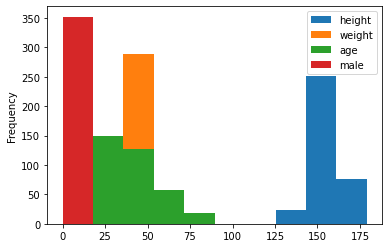

In [18]:
adult_data.plot(kind='hist')

We are now ready to define the model using pyMC's formula syntax. The model definition is the same as before, but we'll repeat it for clarity. We'll also use the same priors as before.

$h_{i} = Normal(mu,sigma)$ <br>
$mu = Normal(178,20)$ <br>
$sigma = Uniform(0,50)$ <br>

In [19]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=adult_data['height'])

We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC3 is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC3 comes with various sampler. Some sampler are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive procedure as in STAN 'jitter+adapt_diag', which start with a identity mass matrix and then adapt a diagonal based on the variance of the tuning samples. 

In [20]:
with m4_1:
    trace_4_1 = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:03<00:00, 2746.86draws/s]
The acceptance probability does not match the target. It is 0.8842063526095278, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages

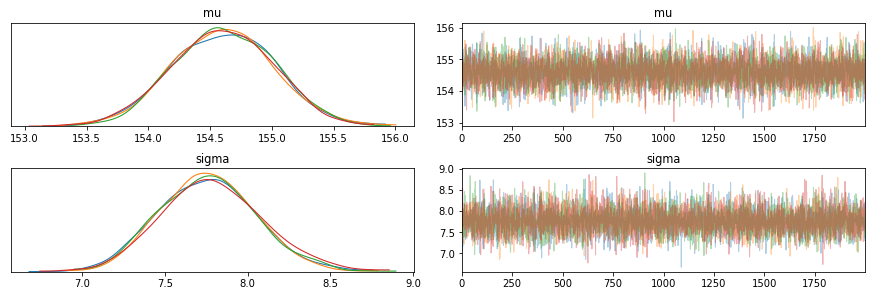

In [21]:
pm.traceplot(trace_4_1); # this function let you check the samples values

In [22]:
pm.summary(trace_4_1).round(2)

mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
mu     154.60  0.41  153.84   155.36        0.0      0.0    7592.0  7592.0   
sigma    7.76  0.29    7.22     8.32        0.0      0.0    7108.0  7068.0   

       ess_bulk  ess_tail  r_hat  
mu       7592.0    6175.0    1.0  
sigma    7154.0    5085.0    1.0

# Linear Prediction

What we've done above is a gaussian model of height in a population of adults. But it doesn't really have the usual feel of 'regression' to it. Typically, we are interested in modelling how to outcome is related to some other vairable,a PREDICTOR VARIABLE. If the predictor variable has any statistical association with the outcome variable, then we can use it to predict the outcome. When the predictor variable is built inside the model in a particular way, we'll call it linear regression.

So now lets look at how height in these Kalarahi foragers (the outcome variable) covaries with weight (the predictor variable). This isn't the most thrilling scientific question, I know. But it is an easy relationship to start with, and if it seems dull, its because you don't have a theory about growth and a history of life in mind. If you did, it would be thrilling. We'll try later on to add some of that thrill, when we consider this example from a more casual perspective. Right not, I ask only that you focus on the mechanics of estimating an association between two variables.

Lets plot height and weight against one another to get an idea of how they covary

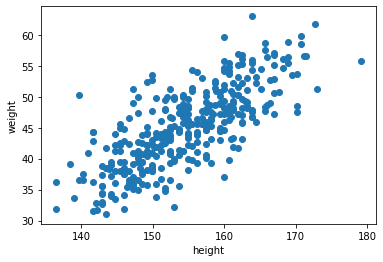

In [23]:
plt.scatter(adult_data['height'], adult_data['weight'])
plt.xlabel('height')
plt.ylabel('weight')
plt.show()

Once you see the plot, you can see there is obviously a relationship. Knowing a persons weight helps you predict height. To make this vague observation into a more precise quantitative model that relates values of weight to plausable values of height, we need somre more technology. How do we take our gaussian model from the previous section and incorporate predictor variables?

### The linear model strategy
The strategy is to make the parameter for the mean of a gaussian distribution, mu, into a linear function of the predictor variable and other, new parameters that we invent. This strategy is often simply called THE LINEAR MODEL. The linear model strategy instructs the golem to assume that a predictor variable has a constant and additive relationship to the mean of the outcome. The golem then computes the posterior distribution of this constant relationship.
What this means, recall, is that the machine considers every possible combination of the parameter values. With a linear model, some of the parameters now stand for the strength of association between the mean of the outcome, mu, and the value of some other variable. For each combination of values the machine computes the posterior probability, which is a measure of the relative plausability, given the model and data. So the posterior distribution ranks the infinite possible combinations of parameters by their logical plausability. As a result, the posterior distribution provides relative plausabilities of the different posssible strengths of association, given the assumptions you programmed into the model. We ask the golem "consider all the lines that relate one variable to another. Rank all of these lines by plausability, given the data". The golen answers with a posterior distribution.

Now how do we get weight into a Gaussian model of height? Let x be the name for the column of weight measurements, let the average of the x values be xbar, now we have a predictor variable x, which is the list of measures of the same length as h. To get weight into the model, we define the mean mu as a function of the values in x. This is what it looks like, with explanation to follow:

$h_{i} = Normal(mu_{i},sigma)$     *likelihood*   <br>
$mu = alpha + beta(x-xbar)$    *linear model*  <br>
$alpha = Normal(178,20)$        *alpha prior* <br>
$beta = Normal(0,10)$           *beta prior*  <br>
$sigma = Uniform(0,50)$         *sigma prior* <br>

#### Probability of the data
Lets begin with just the probability of the observed height, the first line of the model. This is nearly identical to bfore, except now there is a little index i on the mu as well as the h. You can read h_{i} as 'each h' and u_{i} as 'each mu'. The mean mu now depends upon unique values on each row i. So the little i on mu indicates that the *mean depends on the row*
 
#### Linear Model
The mean mu is no longer a parameter to be estimated. Rather, as seen in the second line of the model, the mean is constructed from other parameters, *alpha* and *beta*, and the observed variable *x*. This line is not a stochastic relationship - there is no ~ in it, but rather a = in it - because the definition of mu is deterministic. That is to say that, once we know *alpha*, *beta* and $x_{i}$, we know mu with certainty.

The value $x_{i}$ is just the weight value on row *i*. It refers to the same individual as the height value, $h_{i}$, on the same row. The parameters alpha and beta are more mysterious. Where did they come from? We made them up. The parameters mu and sigma are necessary and sufficient for manipulating mu, allowing it to vary systematically across cases in the data.
You'll be making all manner of parameters as your skills improve. One way to understand these made-up parameters is to think of them  as targets for learning. Each parameter is something that must be described in the posterior distribution. So when you want to know something about the data, you ask your golem by inventing a parameter for it. This will make more and more sense as you progress. Here is how it works in this context. The second line of the mode definition is just:

$ mu = alpha + beta(x_{i} - xbar)$

What this tells the regression golem is that you are asking two questions about the mean of the outcome.

1) what is the expected height when x = xbar. The answer is alpha, because this is the intercept. <br>
2) what is the change in expected height, when $x_{i}$ changes by one unit. The parameter beta answers this question and is referred to as the slope.


#### Priors
The remaining lines in the model define distributions for the unobserved variables. These variables are commonly knows as parameters, and their distributions as priors. There are three parameters alpha, beta, and sigma. We've seen alpha and sigma before, although alpha was called mu back then.

The prior beta deserves explanation. Why have a gaussian prior with mean zero? This prior places just as much probability below zero as it does above zero, and when beta=0 weight has no relationship to height. To figure out what this distribution implies, we have to simulate the prior predictive distribution. There is no other reliable way to understand.
The goal is to simulate heights from the model, using only the priors. First lets consider a range of weight values to simulate over. The range of observed weights will do fine. Then we need to simulate a bunch of lines, the lines implied by the priors alpha and beta.

To start with, lets assume the following

$alpha = Normal(178,20)$  This is the same prior as our mean from before <br>
$beta = Normal(0,10)$ This is the new prior for the slope

In [24]:
alpha = norm.rvs(size =100, loc=178, scale = 20)
beta = norm.rvs(size =100,loc = 0, scale = 10)
weight = adult_data['weight']
mean_weight = np.mean(weight)


# uncomment this line to play with lognormal rather than normal dsitribution for 
#beta = np.log(beta)

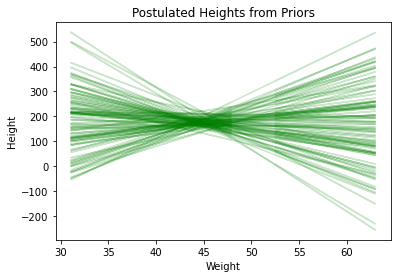

In [25]:
for i in range(len(alpha)):
    height = alpha[i] + beta[i]*(weight - mean_weight)
    plt.plot(weight, height, alpha=0.2, c='g')

plt.title('Postulated Heights from Priors')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

Starting with the standard normal relationship, we see we get some reallh absurd predicted heights. And in many instances we get a negative relationship between height and weight. This is clearly wrong. Can we do any better? yes!

By using a lognormal prior for beta, rather than a normal, we can enforce the values to be strictly positive. Re-running the above code with the logged values shows a series of predicted heights as much more sensible.

We are fussing about this prior, even through as you'll see in the next section there is so much data in this example that the priors end up not mattering. We fuss for two reasons. Fiirst there are many analyses in which no amount of data makes the prior irrelevant. In such cases non-bayesian procedures are no better off. They also depend on structure features of the model. Paying careful attention to those features is essential. Second, thinking about priors helps us develop better models.

### Finding the posterior distribution
The code needed to approximate the posterior is a straightforward modification of the kind of code you've already seen. All we have to do is incorporate our new model for the mean into the model specification inside pymc and be sure to add a prior the new parameter beta.

In [26]:
with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd = 20)
    beta = pm.Lognormal('beta', mu=0, sd = 1)
    sigma = pm.Uniform('sigma', lower = 0, upper = 50)
    mu = alpha + beta *(adult_data['weight'] - adult_data['weight'].mean())
    height = pm.Normal('height', mu=mu, sd = sigma, observed = adult_data['height'])
    trace4_3 = pm.sample(2000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:04<00:00, 2567.02draws/s]


/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/jopa/opt/anaconda3/envs/stats/lib/python3.8/site-packages

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

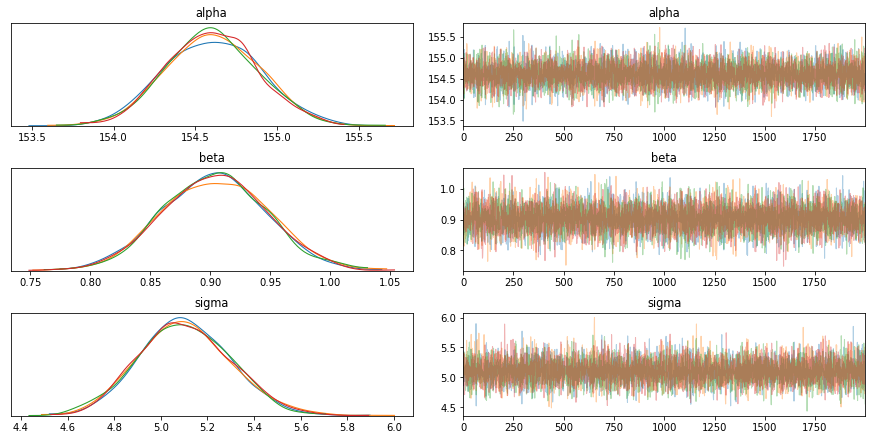

In [27]:
#Then lets sample from this distribution and view the trace
pm.traceplot(trace4_3)

In [28]:
pm.summary(trace4_3).round(2)

mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
alpha  154.6  0.28  154.10   155.14        0.0      0.0   11348.0  11348.0   
beta     0.9  0.04    0.82     0.98        0.0      0.0   10221.0  10221.0   
sigma    5.1  0.20    4.74     5.47        0.0      0.0   10118.0  10028.0   

       ess_bulk  ess_tail  r_hat  
alpha   11296.0    5931.0    1.0  
beta    10211.0    5496.0    1.0  
sigma   10254.0    6103.0    1.0

### Interpreting the posterior distribution
One trouble with statistical models is that they are hard to understand. Once you've fit the model, t can only report posterior distribution. This is the right answer to the question you've asked, but its your responsibility to process the answer and make sense of it.
I emphasise plotting postrerior distributions and posterior predictions, instead of attempting to understand the table. Plotting the implications of your models will allow you to inquire about things that are hard to read from the tables:

1) Whether or not the model fitting procedure worked corrrectly <br>
2) The absolute magnitude, rather than merely the relative magnitude of a relationship between an outcome and a predictor. <br>
3) The uncertainty surrounding the average relationship <br>
4) The uncertainty surrounding the implied predictions of the model, as these are distinct from mere parameter uncertainty <br>

#### Plotting posterior infrence against the data
Its almost always much more useful to plot the posterior inference against the data. Not only does plotting help in interpreting the posterior, but it also provides an informal check on model assumptions. When the models predictions don't come close to key observations or patterns in the plotted data, then you might suspect the model either did not fit correctly or is rather badly specified. But even if you treat plots as a way to help in interpreting the posterior, they are invaluable. For simple models like this one, it is possible just to read the table of numbers and understand what the model says. But for even slightly more complex models, especially those that include interaction effects, interpreting posterior distributions is hard. Combine with this the problem of incorporating the information from covariance into your interpretations, and the plots are irreplaceable.

We are going to start with a simple version of this task, superimposing just the posterior mean values over the height and weight data. Then we'll slowly add more and more information to the prediction plots, until we've used the enture posterior distribution.

We'll start with just the raw data and a single line, using the mean of each parameter value in the posterior.

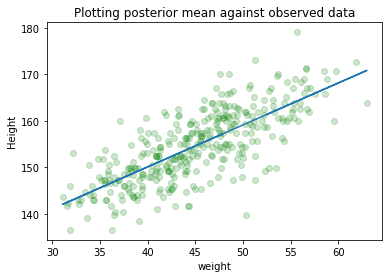

In [29]:
alpha_mean = trace4_3['alpha'].mean()
beta_mean = trace4_3['beta'].mean()

plt.scatter(adult_data['weight'],adult_data['height'],c='g', alpha=0.2)
plt.plot(adult_data['weight'], alpha_mean + beta_mean*(adult_data['weight'] - adult_data['weight'].mean()))
plt.xlabel('weight')
plt.ylabel('Height')
plt.title('Plotting posterior mean against observed data')
plt.show()

#### Adding uncertainty around the mean
The posterior mean line is just the posterior mean, the most plausible line in the infinite universe of lines the posterior distribution has considered, the plot above is OK, but does a poor job of communicating uncertainty. Rememeber the posterior distribution considers every possible regression line connecting height to weight. It assigns relative plausability to each. This means means each alpha and beta has a posterior plausability. It could be that many lines with nearly same posterior probability as the average line. Or it could be instead that the posterior distribution is rather narrrow near the average line.

So how do we get that uncertainty onto a plot? Together, a combination of alpha and beta define the line. And so we could sample a bunch of lines from the posterior distribution. Then we could display those lines on a plot, to visualise the uncertainty in the relationship. To help illustrate this uncertianty, we'll also take smaller snippets of the original data, and see how the scatter in the posterior mean changes. This is known as EPISTEMIC UNCERTAINTY

In [30]:
N=len(adult_data)
sample = adult_data.head(N)
sample

height     weight   age  male
0    151.765  47.825606  63.0     1
1    139.700  36.485807  63.0     0
2    136.525  31.864838  65.0     0
3    156.845  53.041915  41.0     1
4    145.415  41.276872  51.0     0
..       ...        ...   ...   ...
534  162.560  47.031821  27.0     0
537  142.875  34.246196  31.0     0
540  162.560  52.163080  31.0     1
541  156.210  54.062496  21.0     0
543  158.750  52.531624  68.0     1

[352 rows x 4 columns]

## Tangent - Sampling from the prior using PyMC3's framework
Above we were sampling from the prior by just creating our prior distributions outside the modelling framework, and doing the process 'manually'. Here we are going to use the functionality inside pymc to sample from the priors. Hopefully this will improve workflow and efficiency.

In [45]:
with pm.Model() as m4_48:
    alpha = pm.Normal('alpha', mu=178, sd = 20)
    beta = pm.Lognormal('beta', mu=0, sd = 1)
    sigma = pm.Uniform('sigma', lower = 0, upper = 50)
    mu = pm.Deterministic('mu', alpha + beta *(sample['weight'] - sample['weight'].mean()))
    height = pm.Normal('height', mu=mu, sd = sigma, observed = sample['height'])
    
    # take samples from the prior
    prior_checks = pm.sample_prior_predictive(samples=50)
    

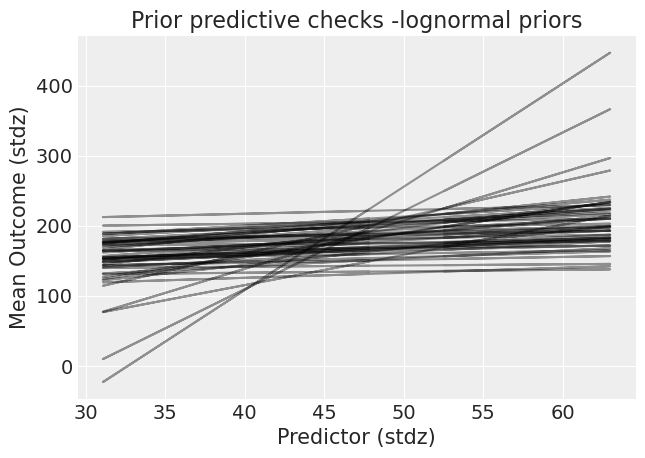

In [47]:
# plotting from the prior predictive distribtuion

_, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["alpha"], prior_checks["beta"]):
    y = a + b * (adult_data['weight'] - adult_data['weight'].mean())
    ax.plot(adult_data['weight'], y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -lognormal priors");

In [49]:
# With the model set up as part of the prior predictive checks, lets do the full sampling

with m4_48:
    # sample from the posterior
    trace4_48 = pm.sample(2000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:05<00:00, 2146.52draws/s]


In [53]:
sample_trace = pm.trace_to_dataframe(trace4_48)


In [54]:
len(sample_trace)

8000

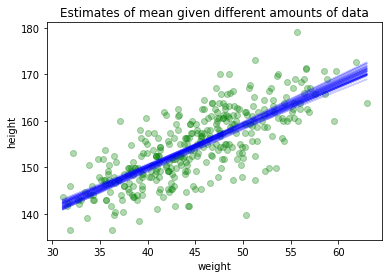

In [35]:
#make the plot - change the number of data points a few cells up to see the sensitivity

plt.scatter(sample['weight'], sample['height'], c='g', alpha=0.3)

for item, row in sample_trace.iterrows():
    plt.plot(sample['weight'], row['alpha'] + row['beta']*(sample['weight'] - sample['weight'].mean()), c='b',alpha=0.2)

plt.title('Estimates of mean given different amounts of data')
plt.xlabel('weight')
plt.ylabel('height')
plt.show()

### Plotting regression intervals and contours
The cloud of regression lines above is useful, but its more common, and much clearer to see the uncertainty displayed by plotting a n interval or contour around the average regression line

In [36]:
trace_df = pm.trace_to_dataframe(trace4_48)
trace_df

alpha      beta     sigma
0     154.648565  0.853351  5.240369
1     154.178248  0.956882  5.031424
2     153.639194  0.890136  5.571811
3     153.629265  0.912433  5.314845
4     153.828787  0.895931  5.183357
...          ...       ...       ...
7995  154.442296  0.979024  5.328795
7996  154.807733  0.813967  5.057888
7997  154.608800  0.982103  5.120091
7998  154.568616  0.835557  4.892524
7999  154.710342  0.949580  5.144417

[8000 rows x 3 columns]

In [76]:
weights = np.linspace(25,71,num=40)

height_array = []

for weight in weights:
    hw_array = []
    
    for i,row in trace_df.head(1000).iterrows():
        pred_height = row['alpha'] + row['beta']*(weight - sample['weight'].mean())
        hw_array.append(pred_height)
    height_array.append(hw_array)
    
result_array = np.asarray(height_array)

In [77]:
perc_95 = np.percentile(result_array,95 ,axis=1)
perc_5 = np.percentile(result_array,5, axis=1)
perc_50 = np.percentile(result_array,50 ,axis=1)



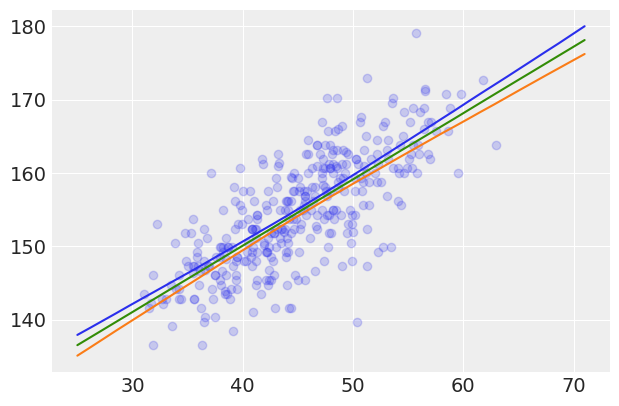

In [79]:
perc_95_mean = np.percentile(result_array,95 ,axis=1)
perc_5_mean = np.percentile(result_array,5, axis=1)
perc_50_mean = np.percentile(result_array,50 ,axis=1)



plt.scatter(adult_data['weight'],
           adult_data['height'],
           alpha=0.2)


    
plt.plot(weights,
        perc_95_mean)
plt.plot(weights,
        perc_5_mean)
plt.plot(weights,
        perc_50_mean)

plt.show()

### Prediction intervals
Now lets walk through generating a prediction interval for actual heights, not just the average height mu. This means we'll incorporate the standard deviation sigma and its uncertainty as well. Rememeber the first line of the statistical model here is:

$ h_{i} = Normal(mu,sigma)$

What you've done so far is just use samples from the posterior to visualise the uncertainty in mu, the linear model of the mean. But actual predictions of height also depend upon the distribution in the first line. The gaussian distribution on the first line tells us that the model expects observed heights to be distributed around mu, not right on top of it. And the spread around mu is governed by sigma. All of this suggests we need to incorporate sigma in the predictions somehow.

Heres how you do it. Imagine simulating heights. For any unique weight value, you sample from a Gaussian distribution with the correct mean mu for that weight, using the correct value of sigma sampled from the same posterior distribution. If you do this for every sample from the posterior, for every weight value of interest, you end up with a collection of simulated heights that embody the uncertainty in the posterior as well as the uncertainty in the Gaussian distribution of heights. Lets do that now.

In [67]:
'''
Steps:
Have 40 weights going from min to max weight
have 200 samples at that weight
for each sample
get the mean
get the standard deviation
make a normal dist
then sample from that'''

from scipy.stats import norm

weights = adult_data['weight']
weights2 = np.linspace(25,71,num=40)
heights_pred_full = []

for weight in weights2:
    curr_weight_obs = []
    for i in range(200):
        posterior_df = sample_trace
        curr_sample = posterior_df[['alpha','beta','sigma']].sample(n=1,replace=True)
        mean = curr_sample['alpha']+ curr_sample['beta']*(weight-weights.mean())
        observation = norm.rvs(loc = mean, scale = curr_sample['sigma'])
        
        curr_weight_obs.append(observation)
        
    heights_pred_full.append(curr_weight_obs)
    

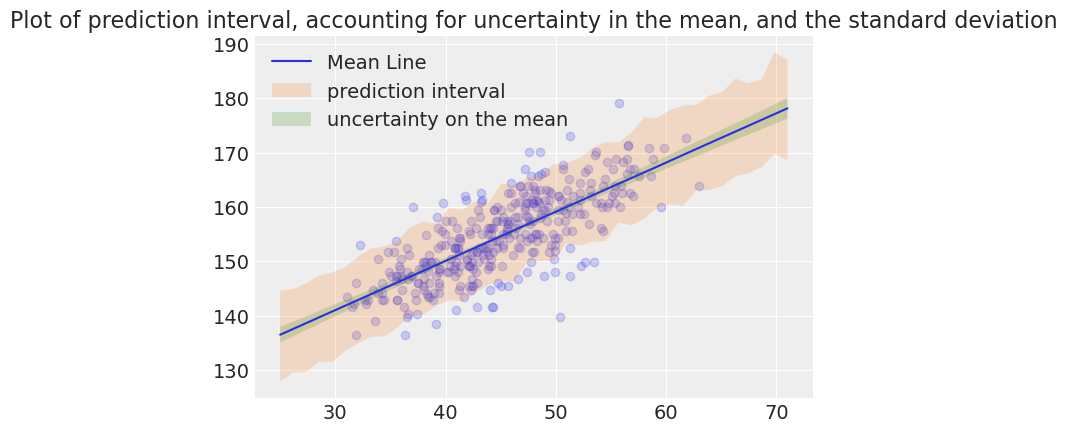

In [83]:
obs_array = np.asarray(heights_pred_full)


perc_95 = np.percentile(obs_array,95 ,axis=1)
perc_5 = np.percentile(obs_array,5, axis=1)
perc_50 = np.percentile(obs_array,50 ,axis=1)



plt.scatter(adult_data['weight'],
           adult_data['height'],
           alpha=0.2)

plt.fill_between(weights2,
                perc_95,
                perc_5,
                alpha=0.2,
                label = 'prediction interval')

plt.fill_between(weights2,
                perc_95_mean,
                perc_5_mean,
                alpha=0.2,
                label = 'uncertainty on the mean')

plt.plot(weights2,
        perc_50_mean,
        label = 'Mean Line')

plt.title('Plot of prediction interval, accounting for uncertainty in the mean, and the standard deviation')
plt.legend()
plt.show()